# Importing Important Libraries

In [1]:
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# make 1000 samples
n_samples = 1000

x, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42
                    )

In [3]:
len(x), len(y)

(1000, 1000)

In [4]:
print(f"The first 5 samples of x: \n{x[:5]}")
print(f"The first 5 samples of y: \n{y[:5]}")

The first 5 samples of x: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
The first 5 samples of y: 
[1 1 1 1 0]


In [5]:
data = pd.DataFrame(
    {"x1" : x[:, 0],
     "x2" : x[:, 1],
     "y" : y}
)

In [6]:
data.head()

,x1,x2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


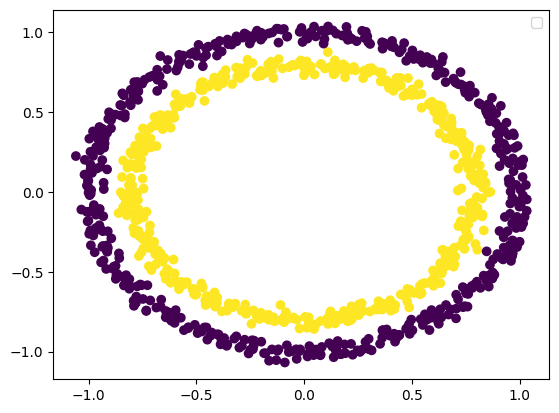

In [7]:
# visualize, visuzlize, visualize
plt.scatter(x=data["x1"], y=data["x2"], c=data["y"])
plt.legend()
plt.show()

In [8]:
type(x)

numpy.ndarray

# Turning Data into Tensors

In [9]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
x[:5], y[:5], type(x), x.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]),
 torch.Tensor,
 torch.float32)

# Splitting the Data

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=42)

In [12]:
x_train.shape, x_test.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

# Device Agnostic Code

In [13]:
 device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
device

'cuda'

# Create the model

In [15]:
class Circle_Model(nn.Module):
  def __init__(self):
    super().__init__()

    # creating the layers of the network
    # self.layer_1 = nn.Linear(in_features=2,
    #                          out_features=5)

    # self.layer_2 = nn.Linear(in_features=5,
    #                          out_features=1)

    # Sequential
    self.two_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
    )

  def forward(self, x:torch.tensor) -> torch.tensor:
    # return self.layer_2(self.layer_1(x))
    return self.two_layers(x)

In [16]:
model_0 = Circle_Model().to(device)

In [17]:
model_0, next(model_0.parameters()).device

(Circle_Model(
   (two_layers): Sequential(
     (0): Linear(in_features=2, out_features=5, bias=True)
     (1): Linear(in_features=5, out_features=1, bias=True)
   )
 ),
 device(type='cuda', index=0))

# Replicating The Circle Model Class

In [18]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [19]:
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

# Initial Predictions

In [20]:
with torch.inference_mode():
  untrained_y_pred = model_0(x_test.to(device))
print(untrained_y_pred.shape)
print(x_test.shape)

torch.Size([200, 1])
torch.Size([200, 2])


In [21]:
untrained_y_pred[:10]

tensor([[-0.1525],
        [ 0.0973],
        [-0.4860],
        [-0.0593],
        [ 0.0241],
        [ 0.1726],
        [ 0.4717],
        [ 0.4906],
        [-0.5070],
        [ 0.1197]], device='cuda:0')

In [22]:
y_test[:10].unsqueeze(dim=1)

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]])

# Picking up a Loss Function and an Optimizer

In [23]:
loss_fn = nn.BCEWithLogitsLoss() # Accepts the the raw logits as input ([z] before activation)
                                 # But BCELoss accepts the prediction probabilities as input ([phiz] After Activation by sigmoid)
optimizer = torch.optim.Adam(params=model_0.parameters(),
                          lr=0.001)

In [24]:
model_0.state_dict()

OrderedDict([('two_layers.0.weight',
              tensor([[-0.3843, -0.3566],
                      [ 0.5859,  0.1729],
                      [-0.3426, -0.5012],
                      [-0.5219, -0.4332],
                      [-0.1735,  0.5107]], device='cuda:0')),
             ('two_layers.0.bias',
              tensor([ 0.3559, -0.2146, -0.1076,  0.6371, -0.2996], device='cuda:0')),
             ('two_layers.1.weight',
              tensor([[ 0.0650,  0.4275, -0.4090, -0.1898, -0.3442]], device='cuda:0')),
             ('two_layers.1.bias', tensor([-0.0240], device='cuda:0'))])

# Defining the Accuracy Function


In [25]:
def accuracy(y_pred, y_true):
  correct = torch.eq(y_pred, y_true).sum().item() # torch.eq() == (torch.equals??),
  accuracy = correct/len(y_pred) * 100
  return accuracy                                             # torch.item() turns a tensor containing a single value into a python number

In [26]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(x_test.to(device))[:5]
y_logits

tensor([[-0.1525],
        [ 0.0973],
        [-0.4860],
        [-0.0593],
        [ 0.0241]], device='cuda:0')

In [27]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4620],
        [0.5243],
        [0.3808],
        [0.4852],
        [0.5060]], device='cuda:0')

In [28]:
torch.round(y_pred_probs)

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.]], device='cuda:0')

# Building the Training & Testing loops

* Device Agnostic Code

In [29]:
x_train, x_test, y_train, y_test = x_train.to(device), x_test.to(device), y_train.to(device), y_test.to(device)

In [30]:
x_train.shape

torch.Size([800, 2])

* Trainig

In [31]:
epochs = 100

for epoch in range(epochs):
  model_0.train()

  # Forward Pass
  logits = model_0(x_train)
  y_pred = torch.round(torch.sigmoid(logits)).squeeze(dim=1)

  # Calculate the loss
  loss = loss_fn(y_pred, y_train)
  acc = accuracy(y_pred=y_pred, y_true=y_train)

  # Optimizer.zero_grad()
  optimizer.zero_grad()

  # Loss Backwards
  loss.backward()

  # Optimizer step step step
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(x_test).squeeze(dim=1)
    y_test_pred = torch.round(torch.sigmoid(test_logits))

    testing_loss = loss_fn(y_test_pred, y_test)
    testing_accuracy = accuracy(y_true=y_test, y_pred=y_test_pred)

  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Training Loss: {loss:.5f} | Training Accuracy: {acc:.2f}% | Testing Loss: {testing_loss:.5f} | Testing Accuracy: {testing_accuracy:.2f}%")



Epoch: 0 | Training Loss: 0.74892 | Training Accuracy: 49.62% | Testing Loss: 0.75580 | Testing Accuracy: 49.00%
Epoch: 10 | Training Loss: 0.74892 | Training Accuracy: 49.62% | Testing Loss: 0.75580 | Testing Accuracy: 49.00%
Epoch: 20 | Training Loss: 0.74892 | Training Accuracy: 49.62% | Testing Loss: 0.75580 | Testing Accuracy: 49.00%
Epoch: 30 | Training Loss: 0.74892 | Training Accuracy: 49.62% | Testing Loss: 0.75580 | Testing Accuracy: 49.00%
Epoch: 40 | Training Loss: 0.74892 | Training Accuracy: 49.62% | Testing Loss: 0.75580 | Testing Accuracy: 49.00%
Epoch: 50 | Training Loss: 0.74892 | Training Accuracy: 49.62% | Testing Loss: 0.75580 | Testing Accuracy: 49.00%
Epoch: 60 | Training Loss: 0.74892 | Training Accuracy: 49.62% | Testing Loss: 0.75580 | Testing Accuracy: 49.00%
Epoch: 70 | Training Loss: 0.74892 | Training Accuracy: 49.62% | Testing Loss: 0.75580 | Testing Accuracy: 49.00%
Epoch: 80 | Training Loss: 0.74892 | Training Accuracy: 49.62% | Testing Loss: 0.75580 | 

In [32]:
model_0.state_dict()

OrderedDict([('two_layers.0.weight',
              tensor([[-0.3843, -0.3566],
                      [ 0.5859,  0.1729],
                      [-0.3426, -0.5012],
                      [-0.5219, -0.4332],
                      [-0.1735,  0.5107]], device='cuda:0')),
             ('two_layers.0.bias',
              tensor([ 0.3559, -0.2146, -0.1076,  0.6371, -0.2996], device='cuda:0')),
             ('two_layers.1.weight',
              tensor([[ 0.0650,  0.4275, -0.4090, -0.1898, -0.3442]], device='cuda:0')),
             ('two_layers.1.bias', tensor([-0.0240], device='cuda:0'))])

# To Analyse the problem, we need to download some helper_functions

In [33]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists!")
else:
  print("Downloading helper_functions.py ...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [34]:
!nvidia-smi

Sun Aug 13 15:00:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |    821MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
from helper_functions import plot_decision_boundary

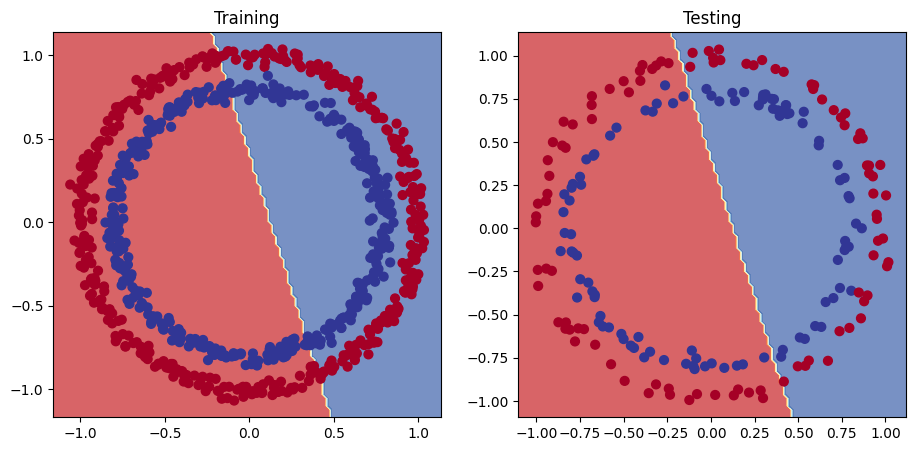

In [43]:
plt.figure(figsize=(11,5)) # width, height
plt.subplot(1,2,1)
plt.title("Training")
plot_decision_boundary(model_0, x_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(model_0, x_test, y_test)